# Lesson 4 solutions 1: Drawing the Mandelbrot set

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<br><br><br><br><br>

## Solutions to exercise 1

In the `run_numpy` function, we can update $z_i$ for all sampled values in the two-dimensional array `c` with

```python
z = z**2 + c
```

and then we'd want to set any elements of `z` that are diverging to the iteration number `i` with

```python
picture[abs(z) > 2] = i
```

except that this would set and re-set those elements as they continue to diverge in the loop over `i`. We need to do the assignment only when array elements _first start_ to diverge. The array elements are initially all set to `20`, so this would do it:

```python
for i in range(20):
    z = z**2 + c
    picture[(picture == 20) & (abs(z) > 2)] = i
```

The final function is

In [2]:
def run_numpy(height, width, real_min=-2, real_max=0.5, imag_min=-1.2, imag_max=1.2):
    y, x = np.ogrid[imag_min:imag_max:height*1j, real_min:real_max:width*1j]
    c = x + y*1j

    z = np.zeros(c.shape, dtype=np.complex128)       # initial values of all elements of z are 0
    picture = np.full(c.shape, 20, dtype=np.int64)   # initial values of all pixels are 20

    for i in range(20):
        z = z**2 + c
        picture[(picture == 20) & (abs(z) > 2)] = i

    return picture

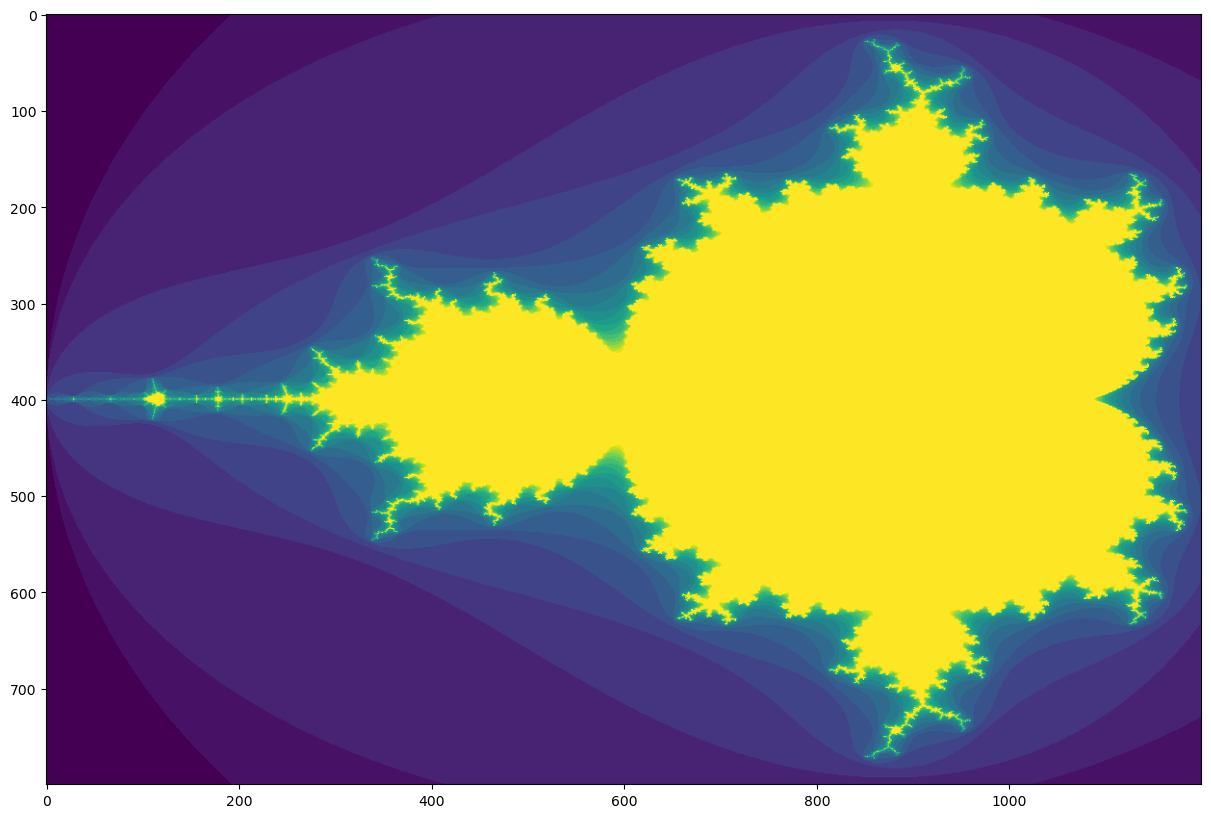

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

with np.errstate(over="ignore", invalid="ignore"):   # ignore warnings about inf and nan values in z
    ax.imshow(run_numpy(800, 1200));

<br><br><br><br><br>

## Solutions to exercise 2

We'd like to just wrap `run_python` with the `@nb.njit` decorator and have it run fast, but there will always be Python language features, data types, and third-party libraries that Numba doesn't know how to replace with compiled code. Currently, [np.ogrid](https://numpy.org/doc/stable/reference/generated/numpy.ogrid.html) is one of those functions.

However, this function does not need to be called in JIT-compiled code. It's only the loops over big data that need acceleration. Therefore, we can split `run_python` into two functions and only JIT-compile one of them.

In [4]:
import numba as nb

In [5]:
def run_numba(height, width, real_min=-2, real_max=0.5, imag_min=-1.2, imag_max=1.2):
    y, x = np.ogrid[imag_min:imag_max:height*1j, real_min:real_max:width*1j]
    c = x + y*1j
    return run_numba_loop(c)

@nb.njit
def run_numba_loop(c):
    picture = np.empty(c.shape, dtype=np.int64)

    for h in range(c.shape[0]):
        for w in range(c.shape[1]):
            z = 0
            for i in range(20):
                z = z**2 + c[h, w]
                if abs(z) > 2:
                    picture[h, w] = i
                    break
            else:
                picture[h, w] = 20

    return picture

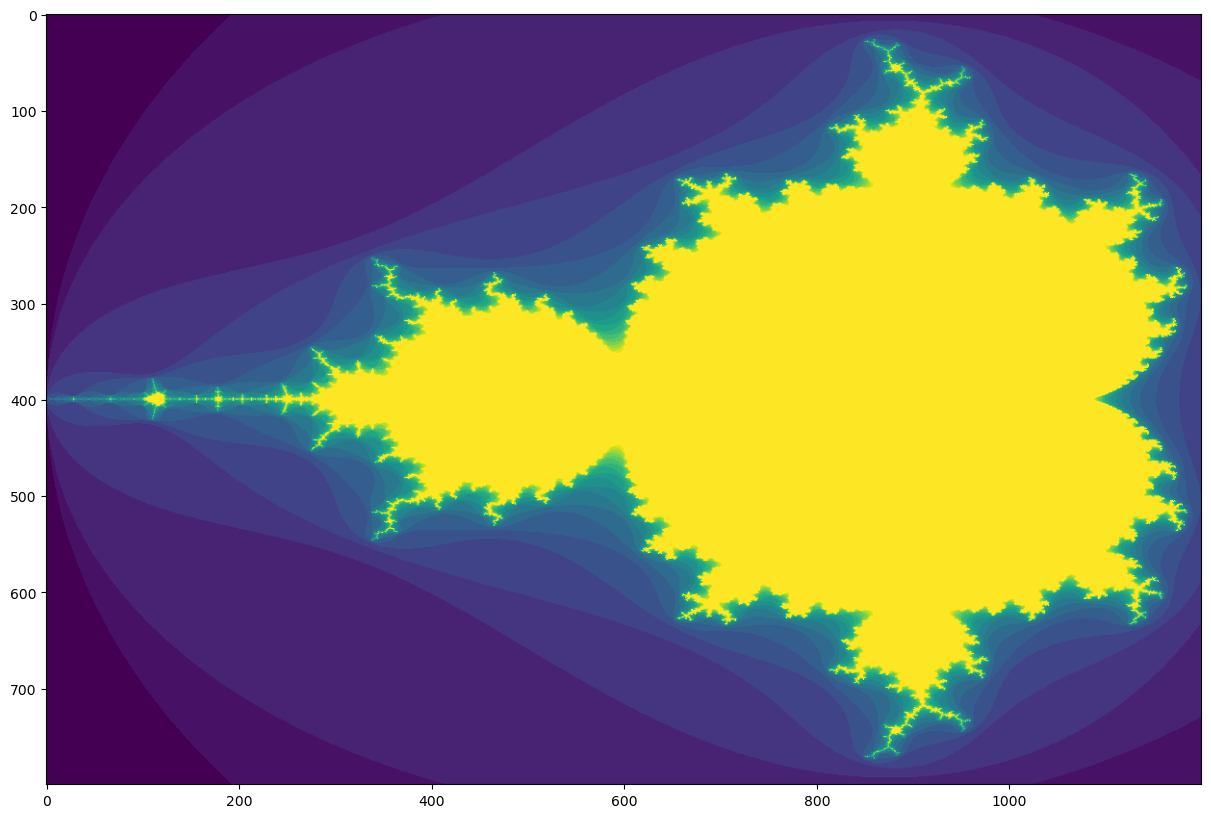

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.imshow(run_numba(800, 1200));

As an alternative, you can use [nb.vectorize](https://numba.readthedocs.io/en/stable/reference/jit-compilation.html#numba.vectorize), which makes a [NumPy ufunc](https://numpy.org/doc/stable/reference/ufuncs.html) (function that implicitly applies to each element of an array independently).

The difference is that there is no explicit loop over array elements of `c` or `z`; they are scalars (a single array element) in this function. `@nb.vectorize` is a special case, but it's a convenient simplification. Our function still has a loop over 20 iterations, so removing the other loops makes the code less complicated.

In [7]:
def run_numba(height, width, real_min=-2, real_max=0.5, imag_min=-1.2, imag_max=1.2):
    y, x = np.ogrid[imag_min:imag_max:height*1j, real_min:real_max:width*1j]
    c = x + y*1j
    return run_numba_loop(c)

@nb.vectorize
def run_numba_loop(c):
    z = 0
    for i in range(20):
        z = z**2 + c
        if abs(z) > 2:
            return i
    else:
        return 20

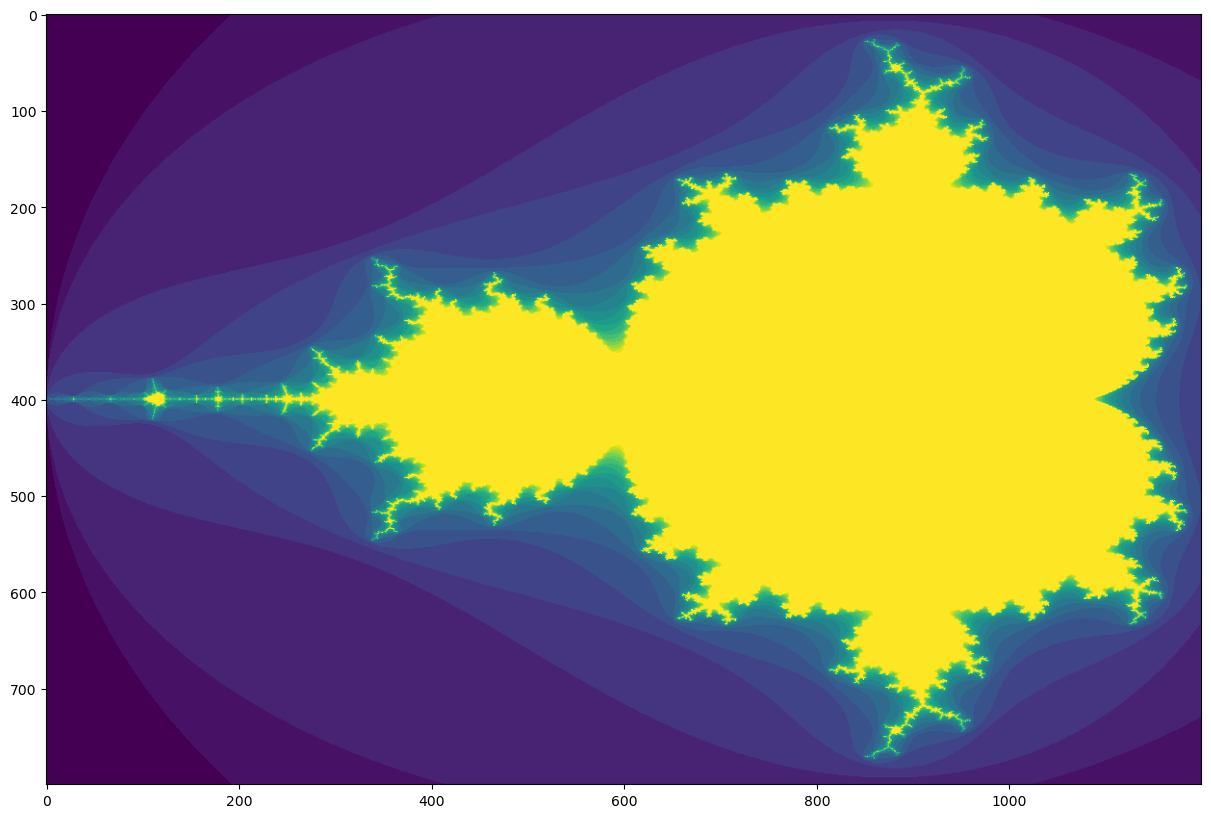

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.imshow(run_numba(800, 1200));

<br><br><br><br><br>

## Solutions to exercise 3

With JAX, we're back to array-oriented programming, so the solution will be similar to `run_numpy`.

However, there are more issues to consider:

* replace all use of `np.*` with `jax.numpy.*`
* factorize into two functions to keep `ogrid` out of the JIT-compiled part
* instead of in-place assignment, use `jax.numpy.where`.

In [9]:
import jax

# https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision
from jax import config
config.update("jax_enable_x64", True)

In [10]:
def run_jax(height, width, real_min=-2, real_max=0.5, imag_min=-1.2, imag_max=1.2):
    y, x = jax.numpy.ogrid[imag_min:imag_max:height*1j, real_min:real_max:width*1j]
    c = x + y*1j
    return run_jax_loop(c)

@jax.jit
def run_jax_loop(c):
    z = jax.numpy.zeros(c.shape, dtype=np.complex128)
    picture = jax.numpy.full(c.shape, 20, dtype=np.int64)

    for i in range(20):
        z = z**2 + c
        picture = jax.numpy.where((picture == 20) & (abs(z) > 2), i, picture)

    return picture

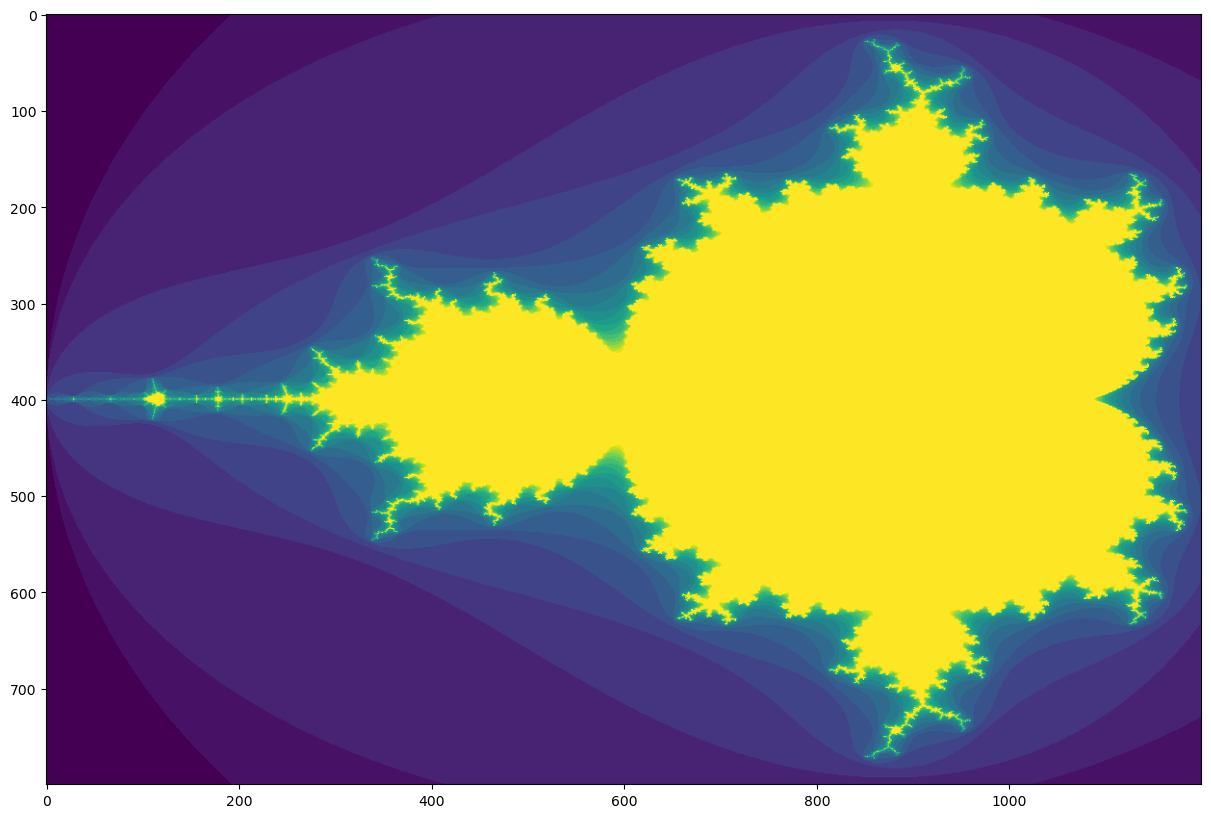

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.imshow(run_jax(800, 1200));